## Distribution of fracture apertures
The algorithm described here was built based on the work published by Ortega _et al._ (2001) in AAPG Bulletin, v.90, no.2.
All data here were collected from outcrops of Aptian lacustrine carbonates in Araripe Basin, NE Brazil. 

### 1. Load libraries and dataset

In [1]:
# Import Python libraries
import numpy as np
import pandas as pd

In [2]:
# Import Visualization libraries
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [3]:
# Load data with Pandas
file_url = "https://raw.githubusercontent.com/gcmatos/structural-geology/master/data/aperture-spacing.csv"
d = pd.read_csv(file_url)
d.head()

,Spacing,Aperture
0,158,0.33
1,160,0.95
2,236,0.95
3,80,0.95
4,218,1.75


In [4]:
# Statistic summary
d.describe()

,Spacing,Aperture
count,202.000000,202.000000
mean,195.004950,3.539035
std,151.295681,2.943369
min,0.000000,0.215000
25%,85.000000,1.400000
50%,163.000000,2.825000
75%,259.250000,5.000000
max,955.000000,18.000000


### 2. Exploratory data analysis - EDA

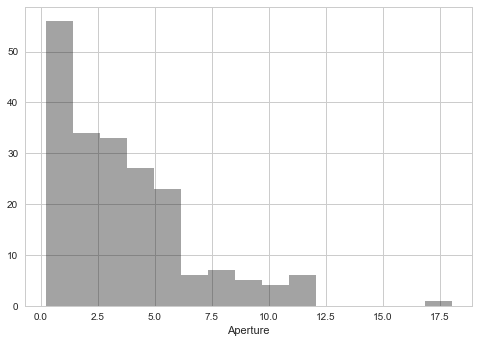

In [5]:
# Aperture distribution
with sns.axes_style("whitegrid"):
    sns.distplot(d.Aperture, kde=False, color='k');

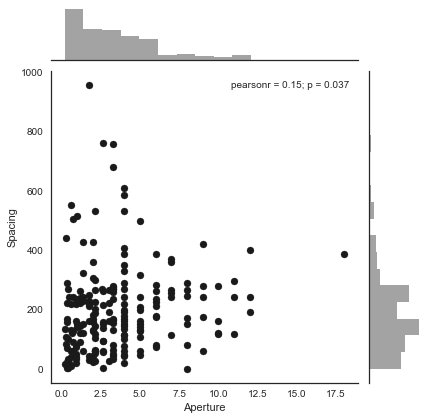

In [6]:
with sns.axes_style("white"):
    sns.jointplot(x="Aperture", y="Spacing", data=d, color='k')

### 3. Features creation

In [7]:
# Aggregation data by Aperture values cummulative sum
A = pd.DataFrame(d.Aperture\
                 .value_counts()\
                 .sort_index(ascending=False))
A.columns = ['Frequency']
A['ApertureClasses'] = A.index
A.index = np.arange(0,len(A),1)

# Calculate the sum of scanline lengths for Intensity
TotalLength = d.Spacing.sum() + d.Aperture.sum()

# Converting Frequency into Intensity (1/m)
A['Intensity'] = A.Frequency / (TotalLength/10E3)
A['CumIntensity'] = A.Frequency.cumsum() / (TotalLength/10E3)
A.head()

,Frequency,ApertureClasses,Intensity,CumIntensity
0,1,18.0,0.24934,0.249340
1,3,12.0,0.74802,0.997360
2,3,11.0,0.74802,1.745380
3,4,10.0,0.99736,2.742740
4,5,9.0,1.24670,3.989439


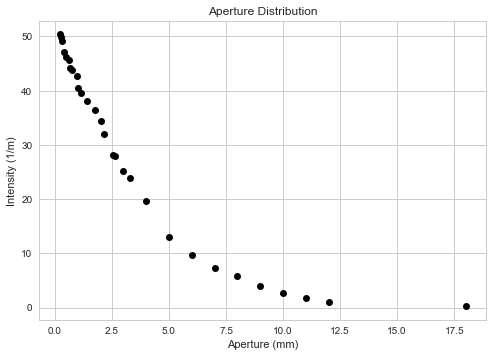

In [8]:
# Plotting script
# Variables
x = A.ApertureClasses
y = A.CumIntensity
# Plotting
ax = plt.axes()
#plt.figure(figsize=(10,5));
plt.plot(x, y, 'o', color='black');
plt.xlabel('Aperture (mm)');
plt.ylabel('Intensity (1/m)');
ax.set_title('Aperture Distribution');


### 4. Curve fitting - Power-law

Power-law fitting is best done by first converting to a linear equation and then fitting to a straight line.
> $y = a * xˆb$

> $log(y) = log(a) + b*log(x)$

This example is based on [Scipy Cookbook](http://scipy-cookbook.readthedocs.io/items/FittingData.html) for fitting a power-law to data with errors.

In [9]:
from scipy import optimize
from scipy.stats import powerlaw

In [10]:
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

# Note: all positive, non-zero data
xdata = A.ApertureClasses
ydata = A.CumIntensity
yerr = ydata

In [11]:
logx = np.log10(xdata)
logy = np.log10(ydata)
logyerr = yerr / ydata

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x # coeficientes de ajuste da função
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), 
                       full_output=1)

pfinal = out[0] # a
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**pfinal[0] # b tirado pelo inverso do log

indexErr = np.sqrt( covar[0][0] )
ampErr = np.sqrt( covar[1][1] ) * amp

[ 1.52301201 -0.92417334]
[[ 0.04627959 -0.03759625]
 [-0.03759625  0.11981841]]


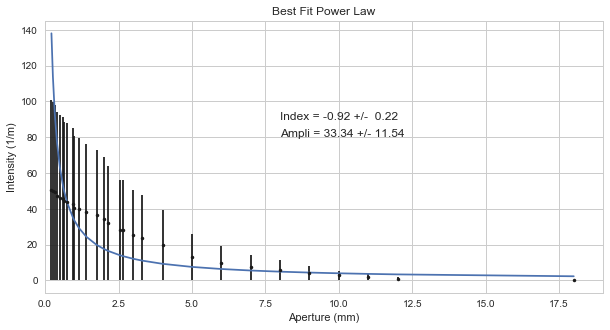

In [12]:
plt.clf();
plt.figure(figsize=(10,5));
plt.plot(xdata, powerlaw(xdata, amp, index));     # Fit
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.');  # Data
plt.text(8, 80, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr));
plt.text(8, 90, 'Index = %5.2f +/- %5.2f' % (index, indexErr));
plt.title('Best Fit Power Law');
plt.xlabel('Aperture (mm)');
plt.ylabel('Intensity (1/m)');
plt.xlim(0, xdata.max() + 1);

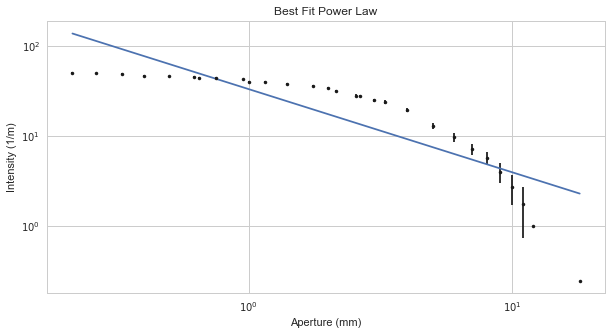

In [13]:
plt.figure(figsize=(10,5));
plt.loglog(xdata, powerlaw(xdata, amp, index));
plt.errorbar(xdata, ydata, yerr=logyerr, fmt='k.');  # Data
plt.title('Best Fit Power Law');
plt.xlabel('Aperture (mm)');
plt.ylabel('Intensity (1/m)');

Power-law curve doesn't fit to dataset because of its strongly curved tale. Let's try another model (Exponential).

### 5. Curve fitting -- Exponential
This example is based on [plotly](https://plot.ly/matplotlib/exponential-fits/) which was inspired by [stackoverflow](http://stackoverflow.com/questions/21420792/exponential-curve-fitting-in-scipy).

In [14]:
from scipy.optimize import curve_fit

In [15]:
def exponential_func(x, a, b, c):
    return a * np.exp(-b*x) + c

In [16]:
popt, pcov = curve_fit(exponential_func, xdata, ydata, p0=(1, 1e-6, 1))
print(popt)
print(pcov)

[ 55.46886769   0.23452277  -2.37975376]
[[  4.41381616e-01  -2.58214090e-03  -3.76060201e-01]
 [ -2.58214090e-03   7.11463415e-05   5.12639912e-03]
 [ -3.76060201e-01   5.12639912e-03   5.06861215e-01]]


In [17]:
xx = np.linspace(xdata.min(), xdata.max(), 1000)
yy = exponential_func(xx, *popt)

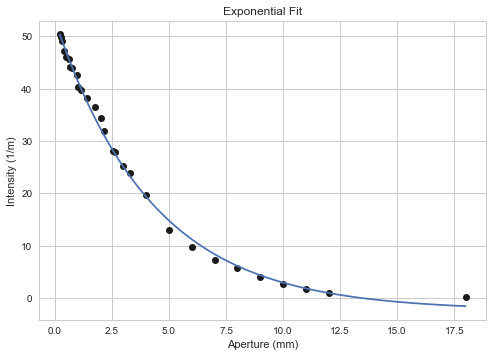

In [18]:
plt.plot(x, y, 'ko', xx, yy);
plt.title('Exponential Fit');
plt.xlabel('Aperture (mm)');
plt.ylabel('Intensity (1/m)');

Exponential curve seems to be the best model for describing the distribution of fracture apertures.